### Importing neccessary libraries :

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
EPS = 0.000001

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


### Grid map representation and allowed moves on a grid

Square grid map class represents agent's environment

- width -- the number of rows in grid
- height -- the number of columns in grid
- cells -- the binary matrix, which represents the grid. 0 - cell is traversable
1 - cell is blocked



In [4]:
class Map:

    # Default constructor
    def __init__(self):
        self.width = 0
        self.height = 0
        self.cells = []
    
    # Initialization of map by string.
    def ReadFromString(self, cellStr, width, height):
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                # TODO
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
    # Initialization of map by list of cells.
    def SetGridCells(self, width, height, gridCells,corner):
        self.width = width
        self.height = height
        self.cells = gridCells
        self.corner = corner

    # Checks cell is on grid.
    def inBounds(self, i, j):
        return (0 <= j < self.width) and (0 <= i < self.height)
    
    # Checks cell is not obstacle.
    def Traversable(self, i, j):
        return not self.cells[i][j]

      # Checks cell is not obstacle.
    def Traversable_(self, i, j, x, y):
        ans = True
        dx = x - i
        dy = y - j
        if dy == 0 or dx == 0:
            return not self.cells[x][y]
          
        d_max = max(abs(dx), abs(dy))

        if d_max == abs(dy):
            if dy > 0:
                for delta_y in range(1, dy + 1):
                    delta_x = dx*delta_y/dy
                    if abs(round(delta_x) - delta_x) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x) + 1][j + math.floor(delta_y)]:
                            ans = False
            else:
                for delta_y in range(dy, 0):               
                    delta_x = dx*delta_y/dy
                    if abs(round(delta_x) - delta_x) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x) + 1][j + math.floor(delta_y)]:
                            ans = False
        else:
            if dx > 0:
                for delta_x in range(1, dx + 1):
                    delta_y = dy*delta_x/dx
                    if abs(round(delta_y) - delta_y) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x)][j + math.floor(delta_y) + 1]:
                            ans = False
            else:
                for delta_x in range(dx, 0):               
                    delta_y = dy*delta_x/dx
                    if abs(round(delta_y) - delta_y) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x)][j + math.floor(delta_y) + 1]:
                            ans = False
        return ans

    
    # Creates a list of neighbour cells as (i,j) tuples.
    def GetNeighbors(self, i, j):
        # TODO Change the function so that the list includes the diagonal neighbors of the cell.
        # Cutting corners must be prohibited
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if self.inBounds(i + di, j + dj) and self.Traversable(i + di, j + dj):
                    if abs(di) + abs(dj) == 1:  # cross
                        neighbors.append((i + di, j + dj))
                    elif abs(di) + abs(dj) == 2:  # diagonal
                        if self.Traversable(i, j + dj) and self.Traversable(i + di, j):
                            neighbors.append((i + di, j + dj))

        return neighbors



Computes a cost of transition from cell `(i1, j1)` to cell `(i2, j2)`

In [5]:
def CalculateCost(i1, j1, i2, j2):
    return math.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

### Node representation

Node class represents a search node

- i, j: coordinates of corresponding grid element
- g: g-value of the node
- h: h-value of the node
- F: f-value of the node
- parent: pointer to the parent-node 

In [6]:
class Node:
    def __init__(self, i, j, g = math.inf, h = math.inf, F = None, parent = None, k=0):
        self.i = i
        self.j = j
        self.g = g
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
        self.k = k
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __lt__(self, other):
        return self.F < other.F or (self.F == other.F and self.k > other.k)

In [7]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    k = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.Traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))

### Open and close sets implementation
A crucial part of any search algorithm (A* including) is the code for handling OPEN/CLOSED 'lists'. Ineffective implementation of these 'lists' may become a bottleneck, expecially for large instances.Here we implement the OPEN and CLOSED lists for our Theta* algorithm

In [8]:
from heapq import heappop, heappush

class YourOpen:
    #!!!TODO!!!
    #Create your own modification of OPEN#
    def __init__(self):
        self.heap = []
        self.ij_to_item = {}
    
    def __iter__(self):
        return iter(self.ij_to_item.values())

    def __len__(self):
        return len(self.ij_to_item)

    def isEmpty(self):
        return len(self.ij_to_item) == 0

    def GetBestNode(self):
        item = heappop(self.heap)
        ij = (item.i, item.j)
        while self.ij_to_item.pop(ij, None) is None:
            item = heappop(self.heap)
            ij = (item.i, item.j)
        return item

    def AddNode(self, item : Node):
        ij = (item.i, item.j)
        item_curr = self.ij_to_item.get(ij)
        if item_curr is None or item.g < item_curr.g or abs(item.g - item_curr.g) < EPS:
            self.ij_to_item[ij] = item
            heappush(self.heap, item)

In [9]:
class YourClosed:
    #!!!TODO!!!
    #Create your own modification of CLOSED#

    def __init__(self):
        self.elements = {}

    def __iter__(self):
        return iter(self.elements.values())
    
    def __len__(self):
        return len(self.elements)
    
    # AddNode is the method that inserts the node to CLOSED
    def AddNode(self, item : Node, *args):
        ij = item.i, item.j
        self.elements[ij] = item

    # WasExpanded is the method that checks if a node has been expanded
    def WasExpanded(self, item : Node, *args):
        ij = item.i, item.j
        return ij in self.elements

## A* algorithm with different heuristics
Implement 3 different heuristic functions besides the given Manhattan distance - Diagonal distance, Chebyshev distance, Euclidean distance. After that, implement A* using YourOpen and YourClosed.

Importanly, your search algorithm needs to return the following:
- boolean flag indicating whether the path was found or not
- goal state (so you can reconstruct the path later using the parent pointers)
- Open and Closed 'lists' so you can use them for further analysis (i.e. computing how many nodes were created within the search process, how many expansions were made etc.)

In [10]:
def EuclidDistance(i1, j1, i2, j2):
    #!!!TODO!!!
    dx, dy = abs(i1 - i2), abs(j1 - j2)
    return math.sqrt(dx**2 + dy**2)

In [11]:
def ThetaStar(gridMap : Map, iStart : int, jStart : int, iGoal : int, jGoal : int, heuristicFunction = EuclidDistance):
    #!!!TODO!!!
    #Implement A* algorithm
    OPEN = YourOpen()
    CLOSED = YourClosed()
    
    
    node_start = Node(iStart, jStart, g=0, h=heuristicFunction(iStart, jStart, iGoal, jGoal))
    node_goal = Node(iGoal, jGoal)
    
    OPEN.AddNode(node_start)
    

    while not OPEN.isEmpty():
        node = OPEN.GetBestNode()
        #print('-'*50)
        #print(node.i, node.j)
        CLOSED.AddNode(node)
        if node == node_goal:
            return True, node, CLOSED, OPEN

        for i, j in gridMap.GetNeighbors(node.i, node.j):
            #print('neighbor', i, j)
            if node.parent is not None and gridMap.Traversable_(node.parent.i, node.parent.j, i, j):
                g_2 = node.parent.g + EuclidDistance(node.parent.i, node.parent.j, i, j)
            else:
                g_2 = 10e8
            g = node.g + EuclidDistance(node.i, node.j, i, j)
            if g_2 < g:
                node_new = Node(i, j, g=g_2, h=heuristicFunction(i, j, iGoal, jGoal), parent=node.parent)
                #print(i, j, g_2, heuristicFunction(i, j, iGoal, jGoal), node.parent)
                      
            else:
                node_new = Node(i, j, g=g, h=heuristicFunction(i, j, iGoal, jGoal), parent=node) 
                #print(i, j, g, heuristicFunction(i, j, iGoal, jGoal), node)
            #print(g, g_2)
            if not CLOSED.WasExpanded(node_new):
                OPEN.AddNode(node_new)

    return (False, None, CLOSED, OPEN)

In [20]:
def AStar(gridMap : Map, iStart : int, jStart : int, iGoal : int, jGoal : int, heuristicFunction = EuclidDistance):
    #!!!TODO!!!
    #Implement A* algorithm
    OPEN = YourOpen()
    CLOSED = YourClosed()
    
    
    node_start = Node(iStart, jStart, g=0, h=heuristicFunction(iStart, jStart, iGoal, jGoal))
    node_goal = Node(iGoal, jGoal)
    
    OPEN.AddNode(node_start)
    
    k = 1
    while not OPEN.isEmpty():
        node = OPEN.GetBestNode()
        CLOSED.AddNode(node)
        if node == node_goal:
            return True, node, CLOSED, OPEN

        for i, j in gridMap.GetNeighbors(node.i, node.j):
            #print('neighbor', i, j)
            g = node.g + EuclidDistance(node.i, node.j, i, j)
            node_new = Node(i, j, g=g, h=heuristicFunction(i, j, iGoal, jGoal), parent=node, k = k) 
            k += 1
            if not CLOSED.WasExpanded(node_new):
                OPEN.AddNode(node_new)

    return (False, None, CLOSED, OPEN)

In [12]:
def MakePath(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [13]:
def SimpleTest(SearchFunction, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, *args):
    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    start = Node(iStart, jStart)
    goal = Node(iGoal, jGoal)

    try:
        result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        if result[0]:
            path = MakePath(result[1])
            correct = abs(path[1] - pathLen) < EPS
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
            Draw(taskMap, start, goal, path[0], nodesExpanded, nodesOpened)

        else:
            print("Path not found!")
            Draw(taskMap, start, goal, None, nodesExpanded, nodesOpened)
            
    except Exception as e:
        print("Execution error")
        print(e)

In [14]:
height = 15
width = 30
mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''
iStart = 1
jStart = 1
iGoal = 13
jGoal = 28
pathLen = 31.9705627

Path found! Length: 30.543355090587678. Nodes created: 154. Number of steps: 76. Correct: False
CPU times: user 28.8 ms, sys: 829 µs, total: 29.6 ms
Wall time: 34.3 ms


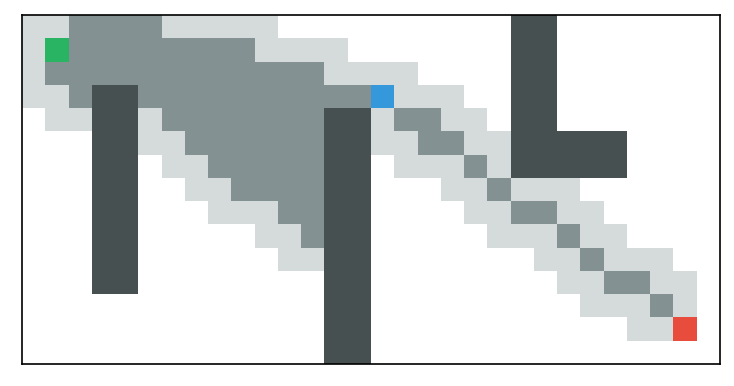

In [15]:
%time SimpleTest(ThetaStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, EuclidDistance)

### Proccessing the Input Data and Storing the Results 
Recall that in this lab you have to use [[MovingAI](https://movingai.com/benchmarks/grids.html)] benchmark as a source dataset for you experiments. So you need to implement functions that will read the data from the dataset, running tests (with validating that your answer is a correct one) and store the obtained results for further analysis.


You can use the provided function definitions to organize your work with the benchmark.

In [16]:
def ReadMapFromMovingAIFile(path):
    #!!!TODO!!!
    mapping = {'.': '.', 'G': '.', '@': '#', 'O': '#', 'T': '#', '\n': '\n'}
    with open(path, 'r') as f:
        f.readline()
        H = int(f.readline().split()[1])
        W = int(f.readline().split()[1])
        f.readline()
        map_str = ''.join(f.readlines())
    map_str = ''.join(map(lambda x: mapping[x], map_str))
    m = Map()
    m.ReadFromString(map_str, W, H)
    return m

In [17]:
def ReadTasksFromMovingAIFile(path):
    #!!!TODO!!!
    tasks = []
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            bucket, map_file, W, H, iStart, jStart, iGoal, jGoal, pathLen = line.split()
            tasks.append((map_file, int(iStart), int(jStart), int(iGoal), int(jGoal), float(pathLen)))
    return tasks 

In [18]:
from tqdm import tqdm
def MassiveTest(SearchFunction, tasks, map_file_prefix, *args):
    allTasksResults = {'found': [], 'length': [], 'true_length': [], 'is_optimal': [], 
                       'nodes_created': [], 'number_of_steps': []}
    #!!!TODO!!!
    for map_file, iStart, jStart, iGoal, jGoal, pathLen in tqdm(tasks):
        allTasksResults['true_length'].append(pathLen)
        m = ReadMapFromMovingAIFile(map_file_prefix + map_file)
        result = SearchFunction(m, jStart, iStart, jGoal, iGoal, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        nodes_created = len(nodesOpened) + len(nodesExpanded)
        number_of_steps = len(nodesExpanded)
        allTasksResults['nodes_created'].append(nodes_created)
        allTasksResults['number_of_steps'].append(number_of_steps)
        if result[0]:
            path = MakePath(result[1])
            correct = abs(path[1] - pathLen) < EPS
            allTasksResults['found'].append(True)
            allTasksResults['length'].append(path[1])
            allTasksResults['is_optimal'].append(correct)
        else:
            allTasksResults['found'].append(False)
            allTasksResults['length'].append(None)
            allTasksResults['is_optimal'].append(None)
            
    return allTasksResults

In [21]:
import pickle

with open('all_tasks.pickle', 'rb') as f:
    all_tasks = pickle.load(f)

In [25]:
%%time
# TODO Run tests using Euclidian heuristic
#arena_tasks = ReadTasksFromMovingAIFile('./arena.map.scen')
#den001d_tasks = ReadTasksFromMovingAIFile('./den001d.map.scen')

#all_tasks = arena_tasks + den001d_tasks

theta_results = MassiveTest(ThetaStar, all_tasks, 'dao-map/', EuclidDistance)


100%|██████████| 200/200 [00:28<00:00,  6.92it/s]

CPU times: user 28.3 s, sys: 132 ms, total: 28.5 s
Wall time: 28.9 s


In [26]:
%%time
a_star_results = MassiveTest(AStar, all_tasks, 'dao-map/', EuclidDistance)


100%|██████████| 200/200 [00:08<00:00, 22.44it/s]

CPU times: user 8.52 s, sys: 72.9 ms, total: 8.6 s
Wall time: 8.92 s


In [27]:
with open('theta_results.pickle', 'wb') as f:
    pickle.dump(theta_results, f)

with open('a_star_results.pickle', 'wb') as f:
    pickle.dump(a_star_results, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Data"

data.zip


In [ ]:
!unzip drive/MyDrive/Data/data.zip

Archive:  drive/MyDrive/Data/data.zip
   creating: data/dao_map/
  inflating: data/dao_map/arena.map  
  inflating: data/dao_map/arena2.map  
  inflating: data/dao_map/brc000d.map  
  inflating: data/dao_map/brc100d.map  
  inflating: data/dao_map/brc101d.map  
  inflating: data/dao_map/brc200d.map  
  inflating: data/dao_map/brc201d.map  
  inflating: data/dao_map/brc202d.map  
  inflating: data/dao_map/brc203d.map  
  inflating: data/dao_map/brc204d.map  
  inflating: data/dao_map/brc300d.map  
  inflating: data/dao_map/brc501d.map  
  inflating: data/dao_map/brc502d.map  
  inflating: data/dao_map/brc503d.map  
  inflating: data/dao_map/brc504d.map  
  inflating: data/dao_map/brc505d.map  
  inflating: data/dao_map/brc997d.map  
  inflating: data/dao_map/brc999d.map  
  inflating: data/dao_map/combat.map  
  inflating: data/dao_map/combat2.map  
  inflating: data/dao_map/den000d.map  
  inflating: data/dao_map/den001d.map  
  inflating: data/dao_map/den005d.map  
  inflating: data/d

In [ ]:
import os
import random

SCEN_PATH = '/content/data/dao_scen'
MAP_PATH = '/content/data/dao_map/'

scen_file_list = sorted(os.listdir(SCEN_PATH))

random.seed(42)
random.shuffle(scen_file_list)

all_tasks = []
for scen_file in scen_file_list[:3]:
    tasks = ReadTasksFromMovingAIFile(os.path.join(SCEN_PATH, scen_file))
    random.shuffle(tasks)
    all_tasks.extend(tasks[:100])

euclid_results = MassiveTest(ThetaStar, all_tasks, MAP_PATH, EuclidDistance)

100%|██████████| 300/300 [03:49<00:00,  1.31it/s]


In [24]:
# TODO
def report(results):
    found = np.array(results['found'])
    is_optimal = np.array(results['is_optimal'])
    length = np.array(results['length'])
    true_length = np.array(results['true_length'])
    nodes_created = np.array(results['nodes_created'])
    number_of_steps = np.array(results['number_of_steps'])

    n = 0
    for x, y in zip(length, true_length):
      if round(x, 8) - y > 0:
        n += 1
        #print(x, y)
    print(n)
    
    print('Found path ratio: ', np.mean(found))
    #print('Optimal path ratio: ', is_optimal[found].mean())
    #print('Mean path error: ', np.abs(1 - (1e-7 + length[found]) / (1e-7 + true_length[found])).mean())
    print('Mean of Length:', length.mean())
    print('Mean of True Length:', true_length.mean())
    print('Mean number of steps: ', number_of_steps.mean())
    
    plt.figure(figsize=[15, 5])
    
    plt.subplot(1, 2, 1)
    plt.scatter(true_length, nodes_created)
    plt.yscale('log')
    plt.xlabel('Path length')
    plt.ylabel('Number of created nodes, log scale')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.scatter(true_length, number_of_steps)
    plt.yscale('log')
    plt.xlabel('Path length')
    plt.ylabel('Number of steps, log scale')
    plt.grid()

    #df = pd.DataFrame(data=np.column_stack((length,true_length)),columns=['length of our path','true_length of the path'])
    #print(df)

1
Found path ratio:  1.0
Mean of Length: 55.409001658078324
Mean of True Length: 57.933106750099995
Mean number of steps:  469.58


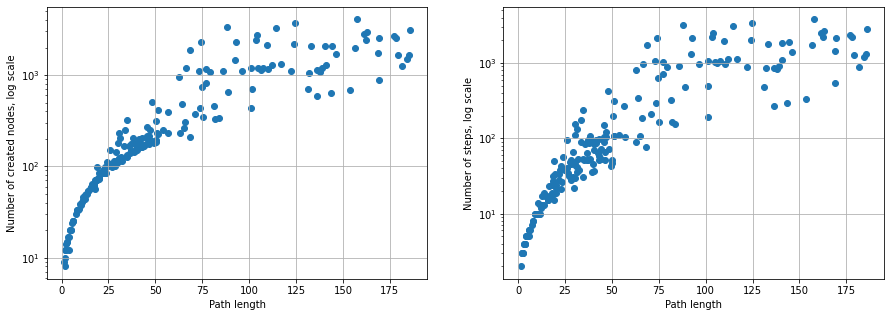

In [25]:
report(euclid_results)

In [26]:
with open('results_6.pickle', 'rb') as f:
    results_6 = pickle.load(f)

In [28]:
for i in range(200):
    if euclid_results['length'][i] - results_6['length'][i] > 10e-5:
        print(i, euclid_results['length'][i], results_6['length'][i])

3 46.64753305245605 46.231247368645384
8 27.78803875660999 27.723543654364008
14 15.615071557183004 15.449659909380486
15 43.94077570625443 43.86332106999758
20 40.77032961426901 40.67395458852605
23 38.41421356237309 38.291438042582165
30 28.242150068137285 27.83701901914063
33 22.495762294674147 22.475997456837067
38 29.160255680657446 28.63409077461869
43 29.766957659018175 29.71460152426817
48 28.3172790631008 28.30192415129037
52 32.67443498296126 32.48885193835461
61 37.35738367241754 37.35204752937991
74 33.268733633656744 33.23691603614989
80 47.48178755071626 47.46044610640056
81 24.499892332319526 23.89292222699217
85 43.89992160332232 43.72582395796939
100 18.884888051888165 18.599091784770806
101 30.199915246428258 29.815350150789396
103 80.55567339756365 80.34857716430638
104 156.41070818771112 156.09485470157853
105 72.16613407129505 70.6156880559932
109 98.55539372795066 98.34345018944613
110 104.32014619693501 102.85600700529967
111 69.59490254685393 69.48667543876232
1

In [29]:
all_tasks[184]

('den001d.map', 91, 23, 141, 25, 66.38477631)

In [30]:
height = 80
width = 211

mapstr = '''
###################################################################################################################################################################################################################
###################################################################################################################################################################################################################
##############################################################################################################################.####################################################################################
##############################################################################################################################.####################################################################################
#################################################################################.............##..............################.#################..............##............#######################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
################################################################################.............................................................................................######################################
################################################################################..............................................#..............................................######################################
#################################################################################............####################............####............###################...........########################################
###################################################################################........##########################....############....##########################........########################################
####################################################################################.......##########################....############....##########################........########################################
####################################################################################.......##########################....############....##########################........########################################
###########....########################......#######################################.......##########.#############........########........########################........########################.###############
###########....########################......######################..####.##########.......##########.###########............####............######################........###############.########.###############
###########..................................#####################........##########.......##########.##...................................................########........##########........####.........#########
##########...................................#####################........##########.......##########.##...................................................########........##########.....................#########
##########...................................##################.......................................##......................................................#####........................................########
##########...................................##################.......................................##......................................................##..........................................#########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................##......##......##................##.........................########
##########...................................####################.....................................##########################################......##########................##...........................######
###########..................................####################.....................................########.......#####.......#####.......###......##########..........................................#########
###########..................................####################.............................................................................##########................................###...............#########
#########......####......####......####......###################..............................................................................##########...............................####...............#########
##########.....####......####......####......####################.............................................................................####..####................................##................#########
##########.....####......####......####......####################..................................................................................................................................######.#########
########.......####......####......####.......#################....................................................................................................................................################
######..........##..................##..........#############......................................................................................................................................################
#####.............................................##########.......................................................................................................................................################
###................................................#######............................................................................................................................................#############
......................................................................................................................................................................................................#############
.....................................................................................................................................................................................................##############
.....................................................................................................................................................................................................##############
.....................................................................................................................................................................................................##############
.....................................................................................................................................................................................................##############
......................................................................................................................................................................................................#############
......................................................................................................................................................................................................#############
####...............................................########........................................................................................................................................################
######............................................###########......................................................................................................................................################
########........##..................##..........###############...................................................................................................................................#################
#########......####......####......####.......##################..................................................................................................................................#######...#######
##########.....####......####......####......####################.......................................................................................................................#..........####...#########
#########......####......####......####......####################.............................................................................##########...............................###................#########
##########.....####......####......####......###################..............................................................................##########...............................####...............#########
###########..................................##################...............................................................................##......##................................##................#########
###########..................................####################.....................................##########################################......##########................##........................#########
##########...................................####################.....................................##########################################......##########................##.........................########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................................##..........................................#########
##########...................................####################.....................................##......................................................##...........................................########
##########...................................####################.........##########.......##########.##......................................................#####........##########........................######
##########...................................#####################........##########.......##########.##...................................................########........##########.....................#########
###########..................................#####################........##########.......##########.##.....####............####............####..........########........###############...####.........#########
###########....########################......#######################################.......##########.#############........########........########################........########################.###############
####################################################################################.......##########.#############........########........########################........########################.###############
####################################################################################.......##########################....############....##########################........########################################
###################################################################################........##########################....############....##########################........########################################
##################################################################################..........#########################....############....########################............######################################
##################################################################################..........###................#.............###.............##................#.............######################################
################################################################################.............................................................................................######################################
################################################################################.............................................................................................######################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
##################################################################################..........####.............##################################.............####............#######################################
###################################################################################################################################################################################################################
###################################################################################################################################################################################################################
###################################################################################################################################################################################################################
'''

Path found! Length: 63.38940996999313. Nodes created: 1189. Number of steps: 983. Correct: False


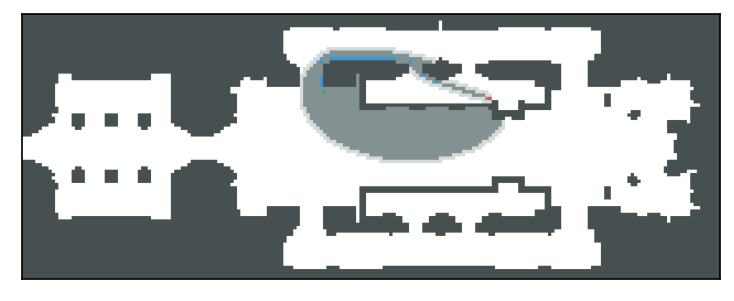

In [31]:
testMap = Map()
testMap.ReadFromString(mapstr, width, height)
#91, 23, 141, 25, 66.38477631
SimpleTest(ThetaStar, height, width, mapstr, 23, 91, 25, 141, 56.62741699, EuclidDistance)